<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/emb/emo_emb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q keras-tuner
# !rm -r emotion
# !git clone --branch main https://github.com/ppkgtmm/emotion.git emotion

In [4]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import  Tokenizer
from emotion.models import utils, emb
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperParameters

In [17]:
num_words = 15000
max_len = 300
hp = HyperParameters()
hp.Choice('output_dim',[16, 32, 64, 128, 256])
hp.Choice('optimizer', ['adam', 'nadam', 'amsgrad'])
hp.Fixed('max_len', max_len)
hp.Fixed('num_words', num_words)
seed = 1234

In [8]:
train, test = utils.read_and_split()
train.sample(5)

,text,target
18073,i can feel that they are kind friendly and can...,joy
14849,i would even say are important as far as how m...,sadness
497,i am not working out the amount i would like t...,joy
3653,i will feel so glad to go sing me to sleep sin...,joy
17135,i get really frustrated whenever i talk with t...,love


In [9]:
train.shape, test.shape

((17000, 2), (3000, 2))

In [10]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [11]:
sequence_train = utils.get_sequences(tokenizer, train['text'], max_len)
sequence_test = utils.get_sequences(tokenizer, test['text'], max_len)

In [12]:
print(train['target'].unique(), train['target'].unique())

['fear' 'joy' 'sadness' 'anger' 'surprise' 'love'] ['fear' 'joy' 'sadness' 'anger' 'surprise' 'love']


In [14]:
target_train = utils.OH_fit_transform(train['target'])
target_test = utils.OH_transform(test['target'])

In [20]:
tuner = BayesianOptimization( emb.build_emb,
                              'val_accuracy',
                              12,
                              executions_per_trial=2,
                              hyperparameters=hp, 
                              seed=seed,
                              num_initial_points=5,
                              project_name='/content/drive/MyDrive/__ed__/emb_B32',
                            )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 16)           240000    
_________________________________________________________________
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 28806     
Total params: 268,806
Trainable params: 268,806
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = tuner.search(sequence_train, target_train,
             validation_split=0.1,
             epochs=3)

Trial 12 Complete [00h 02m 59s]
val_accuracy: 0.8605882525444031

Best val_accuracy So Far: 0.8632352948188782
Total elapsed time: 00h 25m 20s
INFO:tensorflow:Oracle triggered exit


In [22]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
output_dim (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'nadam', 'amsgrad'], 'ordered': False}
max_len (Fixed)
{'conditions': [], 'value': 300}
num_words (Fixed)
{'conditions': [], 'value': 15000}


In [23]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/__ed__/emb_B32
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 256
optimizer: adam
max_len: 300
num_words: 15000
Score: 0.8632352948188782
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
max_len: 300
num_words: 15000
Score: 0.8623529374599457
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
max_len: 300
num_words: 15000
Score: 0.8608823716640472


In [24]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
_________________________________________________________________
flatten (Flatten)            (None, 76800)             0         
_________________________________________________________________
dense (Dense)                (None, 6)                 460806    
Total params: 4,300,806
Trainable params: 4,300,806
Non-trainable params: 0
_________________________________________________________________


In [26]:
model = emb.build_emb(tuner.get_best_hyperparameters(num_trials=1)[0])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 256)          3840000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 76800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 460806    
Total params: 4,300,806
Trainable params: 4,300,806
Non-trainable params: 0
_________________________________________________________________


In [27]:
cb = utils.get_callbacks('emb.h5')

In [30]:
history = model.fit(
    sequence_train, target_train,
    validation_split=0.1,
    epochs=15,
    callbacks=cb
)

Epoch 1/15
479/479 [==============================] - 29s 62ms/step - loss: 1.2020 - accuracy: 0.5704 - precision_1: 0.8637 - recall_1: 0.2746 - val_loss: 0.6719 - val_accuracy: 0.8082 - val_precision_1: 0.9031 - val_recall_1: 0.6471

Epoch 00001: val_accuracy improved from -inf to 0.80824, saving model to emb.h5
Epoch 2/15
479/479 [==============================] - 29s 60ms/step - loss: 0.2999 - accuracy: 0.9235 - precision_1: 0.9496 - recall_1: 0.8737 - val_loss: 0.4386 - val_accuracy: 0.8618 - val_precision_1: 0.8959 - val_recall_1: 0.8100

Epoch 00002: val_accuracy improved from 0.80824 to 0.86176, saving model to emb.h5
Epoch 3/15
479/479 [==============================] - 29s 60ms/step - loss: 0.0893 - accuracy: 0.9801 - precision_1: 0.9833 - recall_1: 0.9759 - val_loss: 0.4058 - val_accuracy: 0.8571 - val_precision_1: 0.8797 - val_recall_1: 0.8347

Epoch 00003: val_accuracy did not improve from 0.86176
Epoch 4/15
479/479 [==============================] - 29s 60ms/step - loss: 0

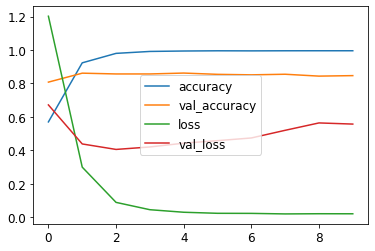

In [32]:
metr = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
pd.DataFrame(history.history)[metr].plot()

28/94 [=======>......................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


94/94 [==============================] - 0s 5ms/step
Accuracy:	84.5%


              precision    recall  f1-score   support

           0       0.85      0.84      0.84       406
           1       0.85      0.71      0.77       356
           2       0.85      0.90      0.87      1014
           3       0.74      0.71      0.72       246
           4       0.88      0.91      0.89       870
           5       0.73      0.57      0.64       108

    accuracy                           0.84      3000
   macro avg       0.82      0.77      0.79      3000
weighted avg       0.84      0.84      0.84      3000



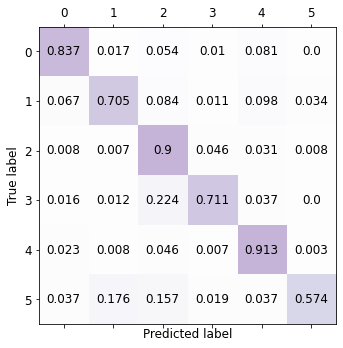

In [74]:
utils.model_evaluate(model, sequence_test, target_test, 32)

In [46]:
# utils.dump(tokenizer,'/content/drive/MyDrive/__ed__/emb_B32/tokenizer.pickle')
# utils.dump(history.history,'/content/drive/MyDrive/__ed__/emb_B32/history.pickle')

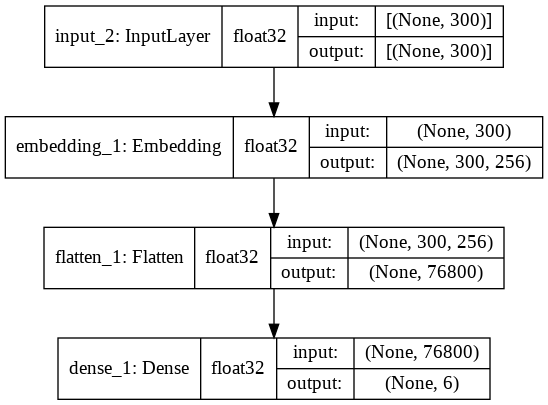

In [48]:
from keras.utils import plot_model
plot_model(
    model,
    to_file='/content/drive/MyDrive/__ed__/emb_B32/plot.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True
    )